# https://raphaelmcobe.github.io/dataSanJose2019_nn_presentation/#/72

In [101]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # For y values
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

import seaborn as sns; sns.set()


In [102]:
np.random.seed(123)  # for reproducibility

## Some Helping Functions

In [103]:
def print_heatmap(data):
    heatmap = sns.heatmap(data)
    heatmap.set(xlabel='Pseudorapidity', ylabel='Azimuthal Angle')
    print(heatmap)
    plt.imshow(data, cmap='jet', interpolation='nearest')
    plt.show()

In [104]:
def get_predicted_values(output_values):
    predicted_values = []
    for probability in output_values:
        if probability[0] > probability[1]:
            predicted_values.append(0)
        else:
            predicted_values.append(1)
    return predicted_values

# Reading the data
First we read the Signal Data and produce a heatmap from the average of all lines. We do so, in order to get the feeling of what our data looks like.

In [105]:
#! wget -c https://github.com/raphaelmcobe/jet-classification/raw/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt

In [106]:
#!ls -lh

In [107]:
signal_data = pd.read_table('signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', header=None)
print(signal_data.shape)
print(signal_data.iloc[1:10,625])

(11298, 626)
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: 625, dtype: float64


As seen, the data read has a last column (no. 626) without data. This happens because the data read has trailing spaces. We need to remove such data.

In [108]:
signal_data.drop(625, axis=1, inplace=True)
print(signal_data.shape)

(11298, 625)


Then, we calculate the average of all observations.

In [109]:
mean_signal = signal_data.mean()
print(mean_signal.iloc[1:10,])

1    0.000000e+00
2    0.000000e+00
3    0.000000e+00
4    0.000000e+00
5    2.397279e-08
6    0.000000e+00
7    6.124087e-08
8    0.000000e+00
9    3.770772e-06
dtype: float64


(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


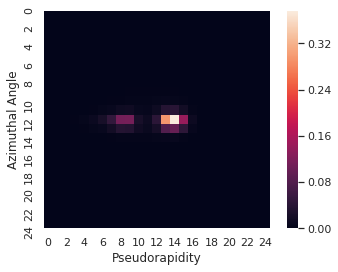

In [110]:
mean_signal_matrix = mean_signal.values
print(mean_signal_matrix.shape)
mean_signal_matrix = mean_signal_matrix.reshape((25,25))

plot_signal_data = print_heatmap(mean_signal_matrix)

We then add a last column, with the value of `1`. This last column classify this data as signal data. After creating the full dataset we will rename this column to _class_.

In [111]:
signal_data[625] = 1

In [112]:

signal_data.iloc[0:10,625]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: 625, dtype: int64

After preprocessing the _signal_ data, we will perform the same steps with the _background_ data.

In [113]:
#!wget -c https://github.com/raphaelmcobe/jet-classification/raw/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt

In [114]:
backgroud_data = pd.read_table('background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', header=None, dtype=np.float32)
print(backgroud_data.shape)

(11298, 626)


In [115]:
backgroud_data.drop(625, axis=1, inplace=True)
print(backgroud_data.shape)

(11298, 625)


In [116]:
mean_background = backgroud_data.mean()
print(mean_background.iloc[1:10,])

1    0.000000e+00
2    0.000000e+00
3    8.339239e-08
4    0.000000e+00
5    1.226879e-06
6    9.698673e-07
7    3.696426e-06
8    8.896710e-06
9    5.325904e-06
dtype: float32


(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


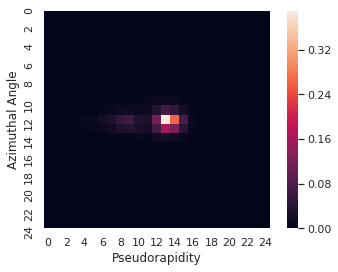

In [117]:
mean_background_matrix = mean_background.values
print(mean_background_matrix.shape)
mean_background_matrix = mean_background_matrix.reshape((25,25))

plot_background = print_heatmap(mean_background_matrix)

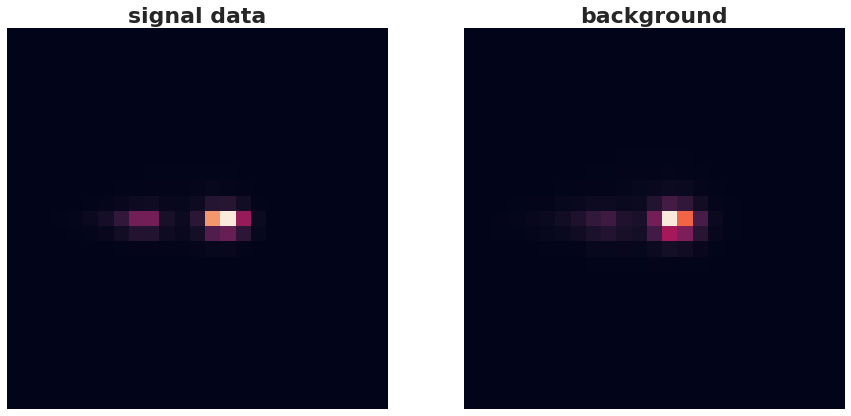

In [118]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax0, ax1 = axes.flatten()
ax0.axis("off")
ax0.imshow(mean_signal_matrix)
ax0.set_title("signal data", fontweight='bold', fontsize=22)
ax1.imshow(mean_background_matrix)
ax1.set_title("background", fontweight='bold', fontsize=22)
ax1.axis("off")
plt.show()

In [119]:
backgroud_data[625] = 0

In [120]:
backgroud_data.iloc[0:10,625]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 625, dtype: int64

Now we concatenate the data and shuffle it in order to randomize its columns.

In [121]:
frames = [signal_data, backgroud_data]
full_data = pd.concat(frames)

In [122]:
full_data = full_data.sample(frac=1).reset_index(drop=True)
full_data.rename(columns={625: 'class'}, inplace=True)

Now let's examine how our data looks like.

In [123]:
from IPython.core.display import display
with pd.option_context('display.max_rows', 200, 'display.max_columns', 15, 
                       'display.float_format', '{:.2f}'.format):
    display(full_data)

,0,1,2,3,4,5,6,...,619,620,621,622,623,624,class
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22591,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22592,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22593,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22594,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0


# Defining and Training the model

In [294]:
from sklearn.preprocessing import Normalizer
X = full_data.drop('class', axis=1)
y = full_data['class']
scaler = Normalizer().fit(X).transform(X)

Split the full dataset into _test_ and _train_ data in a 70-30% rate.

In [295]:
X_train, X_test, Y_train, Y_test = train_test_split(scaler, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)

(15139, 625)
(7457, 625)


The _Keras_ framework, in order to train its network must receive the dependent and independent variables in  separated tables.

In [296]:
print(X_train.shape)
print(Y_train.shape)
display(X_train)

(15139, 625)
(15139,)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [297]:
print(X_test.shape)
print(Y_test.shape)

(7457, 625)
(7457,)


We must convert the dependent variable to be a probability distribution of the possible outcomes, thus, a value of output `1` must become the probabilities `(0, 1)`. Conversely, a `0` outcome value must become the pair `(1, 0)`.

# Why ?

In [298]:
Y_train = to_categorical(Y_train, num_classes=2)
len(Y_train)

15139

In [299]:
len(Y_train)

15139

## Neural Network Architecture Definition
We defined a simple NN, with only two hidden layer.

In [300]:
dimof_input = X_train.shape[1] # quantidade de inputs
model = Sequential()
model.add(Dense(units=625, activation="relu", input_dim=dimof_input))#'relu'
model.add(Dropout(0.1))
model.add(Dense(units=12, activation='sigmoid', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=2))
model.compile(loss='mean_squared_logarithmic_error', optimizer="adam", 
              metrics=["accuracy"]) #mse
dimof_input

625

After defining the NN architecture we train it using the `fit` method. We trained it for 50 epochs (backpropagation cycles). 

In [301]:
historico = model.fit(X_train, Y_train, batch_size=500, epochs=50, verbose=1) #batch_size - numero de linhas/128, serao 52 iteracoes para uma epoch

#custo computacional menor,alocacao de memoria

# desvantagem -menor batch-size --> menor accuracia o gradiente vai ter

Train on 15139 samples
Epoch 1/50
15139/15139 [==============================] - 1s 35us/sample - loss: 0.1543 - accuracy: 0.5132
Epoch 2/50
15139/15139 [==============================] - 0s 11us/sample - loss: 0.1140 - accuracy: 0.6229
Epoch 3/50
15139/15139 [==============================] - 0s 11us/sample - loss: 0.1042 - accuracy: 0.6691
Epoch 4/50
15139/15139 [==============================] - 0s 11us/sample - loss: 0.0997 - accuracy: 0.6874
Epoch 5/50
15139/15139 [==============================] - 0s 11us/sample - loss: 0.0965 - accuracy: 0.7047
Epoch 6/50
15139/15139 [==============================] - 0s 11us/sample - loss: 0.0941 - accuracy: 0.7092
Epoch 7/50
15139/15139 [==============================] - 0s 11us/sample - loss: 0.0914 - accuracy: 0.7168
Epoch 8/50
15139/15139 [==============================] - 0s 11us/sample - loss: 0.0898 - accuracy: 0.7241
Epoch 9/50
15139/15139 [==============================] - 0s 11us/sample - loss: 0.0886 - accuracy: 0.7296
Epoch 10/50
15

After training the model we need to evaluate it.

In [302]:
Y_test = to_categorical(Y_test, num_classes=2)
Y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [303]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.07988709486247011, 0.76398015]


In [304]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

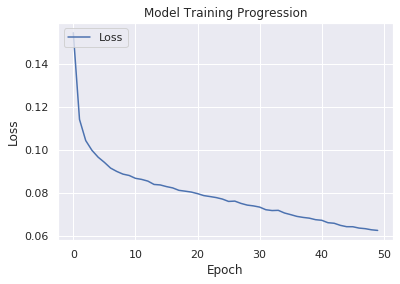

In [305]:
import matplotlib.pyplot as plt
plt.plot(historico.history['loss'])
plt.title('Model Training Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()
#curva de perda

Now let's take a look at the missclassified observations.

In [241]:
Y_test_predicted = model.predict(X_test, verbose=0)

In [ ]:
Y_test_predicted #compara as tuplas

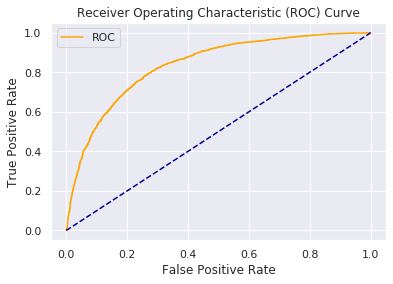

In [285]:
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:, 0]
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
auc = roc_auc_score(Y_test[:, 0], y_pred)
fpr, tpr, thresholds = roc_curve(Y_test[:, 0], y_pred)
plot_roc_curve(fpr, tpr)

Now we calculate the false negatives and also the false positives by comparing the true value with the predicted one.

In [286]:
Y_test_predicted_values = get_predicted_values(Y_test_predicted)
Y_test_values = get_predicted_values(Y_test)

print(len(Y_test_values), len(Y_test_predicted_values))
false_positives = []
false_negatives = []
for i in range(len(Y_test_values)):
    if Y_test_values[i] == 0 and Y_test_predicted_values[i] == 1:
        false_positives.append(i)
    elif Y_test_values[i] == 1 and Y_test_predicted_values[i] == 0:
        false_negatives.append(i)
        
print("False Positive Rate: {:.2f}".format(len(false_positives)/len(Y_test_values)))
print("False Negative Rate: {:.2f}".format(len(false_negatives)/len(Y_test_values)))

7457 7457
False Positive Rate: 0.12
False Negative Rate: 0.12


And try to visualize the heatmaps for false positives and negatives. Firstly the false negatives, where the network was supposed to answer _Signal_, but instead, it answered _Background_.

In [289]:
print(false_negatives[1:10])
false_negatives_values = X_test[false_negatives,]
print(false_negatives_values.shape, len(false_negatives))

mean_false_negatives = false_negatives_values.mean()
print(mean_false_negatives.shape)
mean_false_negatives = mean_false_negatives.reshape((25,25))

print_heatmap(mean_false_negatives)

[17, 44, 45, 63, 66, 80, 92, 95, 96]
(877, 625) 877
()


ValueError: cannot reshape array of size 1 into shape (25,25)

Then we examine the cases in which the network should have responded _Background_, but it answered _Signal_.

[25, 26, 27, 40, 57, 59, 60, 80, 85]
(807, 625)
(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


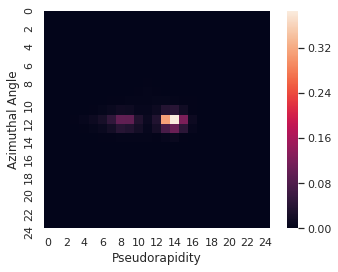

In [57]:
print(false_positives[1:10])
false_positives_values = X_test.iloc[false_positives,]
print(false_positives_values.shape)

mean_false_positives = false_positives_values.mean().values
print(mean_false_positives.shape)
mean_false_positives = mean_false_positives.reshape((25,25))

print_heatmap(mean_false_positives)